##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

keras = tf.keras

In [3]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

--2022-06-17 13:02:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.006s  

2022-06-17 13:02:16 (28.5 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



In [4]:
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [6]:
# Plot the validation and training data separately
def plot_loss_curves(history, metric="mae"):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history[metric]
  val_accuracy = history.history[f'val_{metric}']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(15, 5))
  # Plot loss
  plt.subplot(1, 2, 1)
  plt.title('Loss')
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.title(metric)
  plt.plot(epochs, accuracy, label=f'training_{metric}')
  plt.plot(epochs, val_accuracy, label=f'val_{metric}')
  plt.xlabel('Epochs')
  plt.legend();
  
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]


# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels


# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels


# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments", monitor='val_mae', mode='min'):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            #verbose=0, # only output a limited amount of text
                                            save_weights_only=True,
                                            monitor=monitor,
                                            mode=mode,
                                            save_best_only=True) # save only the best model to file


# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")


def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

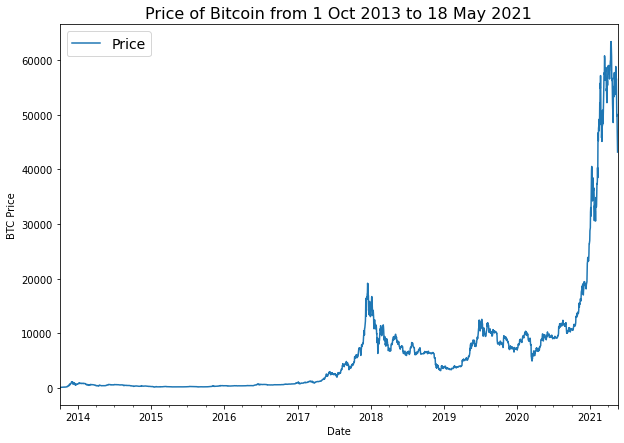

In [7]:
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

In [8]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
bitcoin_prices.head(10)

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866
2013-10-06,120.65533
2013-10-07,121.79500
2013-10-08,123.03300
2013-10-09,124.04900


In [10]:
# Function to create windows using Pandas
def pd_windows(df_dados, target, window_size=7, horizon=1):
  # Make a copy of the Bitcoin historical data with block reward feature
  df_dados_windowed = df_dados.copy()

  labels = []
  # Add windowed columns
  for i in range(window_size, 0, -1): # Shift values for each step in WINDOW_SIZE
    no_column = f"{target}-{i}"
    df_dados_windowed[no_column] = df_dados_windowed[target].shift(periods=i)
    labels.append(no_column)
  
  return df_dados_windowed, labels

In [11]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

# Create a DataFrame with window
df_bitcoin_windowed, labels_window = pd_windows(bitcoin_prices, "Price", window_size=7, horizon=1)

# Drop initial row with nan values
df_bitcoin_windowed = df_bitcoin_windowed.dropna(axis=0).astype(np.float32)

In [12]:
df_bitcoin_windowed[labels_window + ["Price"]].tail()

,Price-7,Price-6,Price-5,Price-4,Price-3,Price-2,Price-1,Price
Date,,,,,,,,
2021-05-14,56583.851562,57107.121094,58788.210938,58102.191406,55715.546875,56573.554688,52147.820312,49764.132812
2021-05-15,57107.121094,58788.210938,58102.191406,55715.546875,56573.554688,52147.820312,49764.132812,50032.691406
2021-05-16,58788.210938,58102.191406,55715.546875,56573.554688,52147.820312,49764.132812,50032.691406,47885.625000
2021-05-17,58102.191406,55715.546875,56573.554688,52147.820312,49764.132812,50032.691406,47885.625000,45604.617188
2021-05-18,55715.546875,56573.554688,52147.820312,49764.132812,50032.691406,47885.625000,45604.617188,43144.472656


In [13]:
test_split = 0.2 # this will default to 80% train/20% test

# Calculate the lenght of train dataset
split_size = int(df_bitcoin_windowed.shape[0] * (1-test_split)) # this will default to 80% train/20% test

target = "Price"

# Make train and test sets
X_train = df_bitcoin_windowed[labels_window][:split_size]
y_train = df_bitcoin_windowed[target][:split_size]
X_test = df_bitcoin_windowed[labels_window][split_size:]
y_test = df_bitcoin_windowed[target][split_size:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2224, 7), (2224,), (556, 7), (556,))

In [14]:
type(X_train), type(y_train)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [15]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {X_train.to_numpy()[i]} -> Label: {y_train.to_numpy()[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: 123.03299713134766
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: 124.04900360107422
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: 125.9611587524414


In [16]:
# plt.figure(figsize=(12, 5))
# plot_time_series(timesteps=y_train.index, values=y_train, label="Train")
# plot_time_series(timesteps=y_test.index, values=y_test,  format="-", label="Test") 

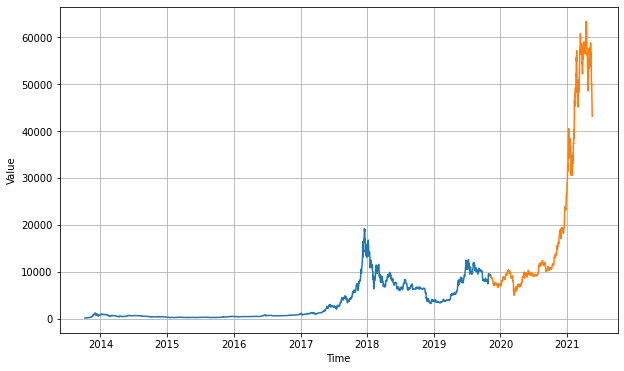

In [17]:
plt.figure(figsize=(10, 6))
plot_series(y_train.index, y_train)
plot_series(y_test.index, y_test)
plt.show()

In [18]:
#Function to create windows using TensorFlow
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    #dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (tf.expand_dims(window[:-1], axis=-1), window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# HORIZON = 1 # predict 1 step at a time
# WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

# print("X_train ", X_train.shape)
# print("X_test ", X_test.shape)

# train_set = window_dataset(X_train, window_size=WINDOW_SIZE, batch_size=32)
# test_set = window_dataset(X_test, window_size=WINDOW_SIZE, batch_size=32)


# X_train_array = []
# y_train_array =  []
# for x, y in train_set.unbatch():
#   X_train_array.append(x.numpy())
#   y_train_array.append(y.numpy())

# X_train_array = np.array(X_train_array)
# y_train_array = np.array(y_train_array)

# print("X_train_array: ", X_train_array.shape)
# print("y_train_array: ", y_train_array.shape)


# X_test_array = []
# y_test_array =  []
# for x, y in test_set.unbatch():
#   X_test_array.append(x.numpy())
#   y_test_array.append(y.numpy())

# X_test_array = np.array(X_test_array)
# y_test_array = np.array(y_test_array)

# print("X_test_array: ", X_test_array.shape)
# print("y_test_array: ", y_test_array.shape)

## Input shape

In [19]:
#Input shape
train_windows = np.expand_dims(X_train.to_numpy(), axis=-1)
train_labels = np.expand_dims(y_train.to_numpy(), axis=-1)
test_windows = np.expand_dims(X_test.to_numpy(), axis=-1)
test_labels = np.expand_dims(y_test.to_numpy(), axis=-1)

train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2224, 7, 1), (556, 7, 1), (2224, 1), (556, 1))

In [20]:
# Function to create TensorFlow Dataset from DataFrame or arrays
def tf_dataset(X, y, batch_size=32, shuffle_buffer=1000):
    features_dataset = tf.data.Dataset.from_tensor_slices(X)
    labels_dataset = tf.data.Dataset.from_tensor_slices(y)
    dataset = tf.data.Dataset.zip((features_dataset, labels_dataset))
    #dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [21]:
# Convert pandas to tf.Dataset
train_set = tf_dataset(train_windows, train_labels, batch_size=32, shuffle_buffer=1000)
test_set = tf_dataset(test_windows, test_labels, batch_size=32, shuffle_buffer=1000)

In [22]:
for window, target in train_set.take(1):
  print(window.numpy()[1].shape, target.numpy()[1].shape)
  print(window.numpy()[1], target.numpy()[1])

(7, 1) (1,)
[[125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]
 [123.033  ]] [124.049]


## Model 0: Naïve forecast (baseline)

In [23]:
# Create a naïve forecast
naive_forecast = test_labels[:-1] # Naïve forecast equals every value excluding the last value

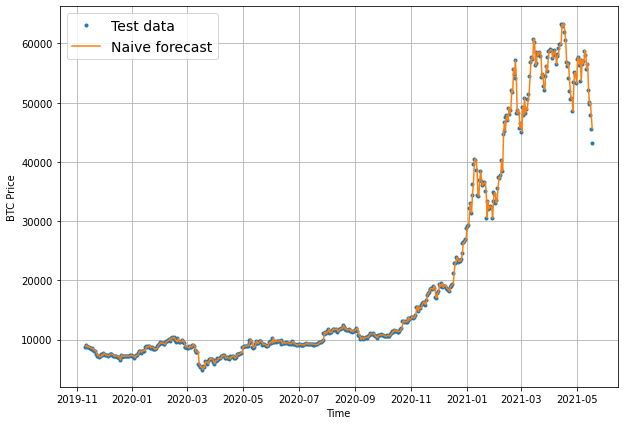

In [24]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
#plot_time_series(timesteps=X_train.index, values=y_train, label="Train data")
plot_time_series(timesteps=X_test.index, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:].index, values=naive_forecast, format="-", label="Naive forecast");

In [25]:
naive_forecast.shape, test_labels[1:].shape

((555, 1), (555, 1))

In [26]:
naive_results = evaluate_preds(y_true=tf.squeeze(test_labels[1:]),
                               y_pred=tf.squeeze(naive_forecast))
naive_results

{'mae': 569.2417,
 'mape': 2.5166645,
 'mase': 0.99909353,
 'mse': 1151345.9,
 'rmse': 1073.0078}

## Model 1: Dense model (window = 7, horizon = 1)

In [27]:
#Input shape

train_windows = X_train.to_numpy()
train_labels = np.expand_dims(y_train.to_numpy(), axis=-1)
test_windows = X_test.to_numpy()
test_labels = np.expand_dims(y_test.to_numpy(), axis=-1)

train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2224, 7), (556, 7), (2224, 1), (556, 1))

In [28]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [37]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# O parâmetro patience é o quantidade de epochs para checar as melhoras
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10)

# Callback to save the best weights during training process
checkpoint_filepath = '/tmp/checkpoint_1'
checkpoint_callback_1 = create_model_checkpoint(model_name=model_1.name, save_path=checkpoint_filepath,  monitor='val_mae', mode='min')


# Fit model
history_model_1 = model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
                              y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
                              epochs=50,
                              verbose=0,
                              batch_size=32,
                              validation_data=(test_windows, test_labels),
                              callbacks=[checkpoint_callback_1], 
                              ) 

# The model weights (that are considered the best) are loaded into the model.
model_1.load_weights(os.path.join(checkpoint_filepath, model_1.name))

In [38]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               1024      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Evaluate model on test data
model_1.evaluate(test_set)

18/18 [==============================] - 0s 2ms/step - loss: 569.6978 - mae: 569.6978


[569.6978149414062, 569.6978149414062]

In [40]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 569.6978 - mae: 569.6978


[569.6978149414062, 569.6978149414062]

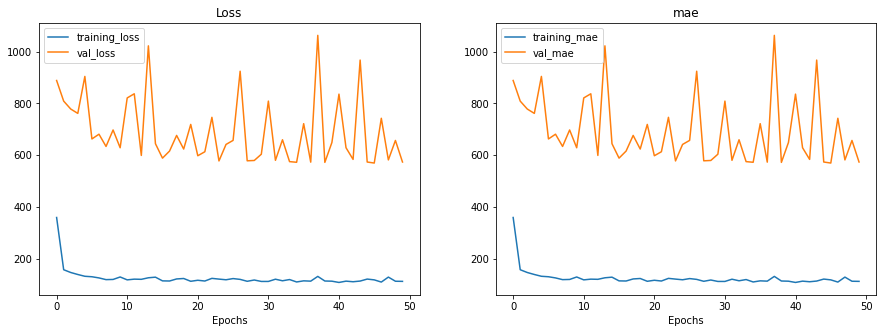

In [41]:
plot_loss_curves(history_model_1, metric="mae")

In [42]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)

# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 569.6979,
 'mape': 2.5459821,
 'mase': 1.0008013,
 'mse': 1179550.4,
 'rmse': 1086.071}

In [43]:
compare_baseline_to_new_results(naive_results, model_1_results)

Baseline mae: 569.24, New mae: 569.70, Difference: 0.46
Baseline mse: 1151345.88, New mse: 1179550.38, Difference: 28204.50
Baseline rmse: 1073.01, New rmse: 1086.07, Difference: 13.06
Baseline mape: 2.52, New mape: 2.55, Difference: 0.03
Baseline mase: 1.00, New mase: 1.00, Difference: 0.00


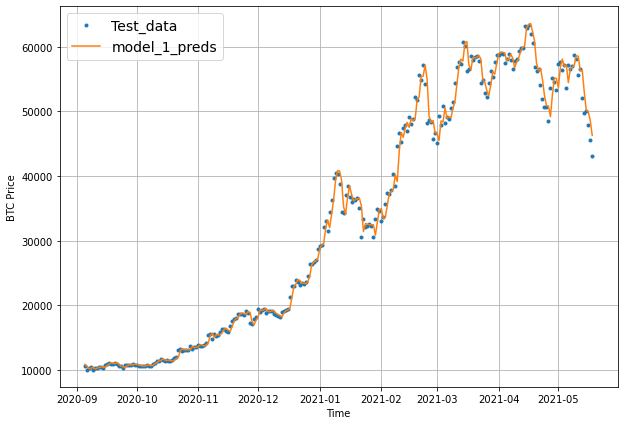

In [44]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=y_test.index, values=test_labels, start=offset, label="Test_data")
plot_time_series(timesteps=y_test.index, values=model_1_preds, start=offset, format="-", label="model_1_preds")

### Save the model

In [45]:
# Save TF Hub Sentence Encoder model to h5 format
model_1.save("model_time_series.h5")

In [46]:
!zip -r model_time_series.zip "model_time_series.h5"

  adding: model_time_series.h5 (deflated 70%)


In [47]:
!ls -hl

total 408K
-rw-r--r-- 1 root root 175K Jun 17 12:45 BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
-rw-r--r-- 1 root root 175K Jun 17 13:02 BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1
-rw-r--r-- 1 root root  39K Jun 17 13:23 model_time_series.h5
-rw-r--r-- 1 root root  12K Jun 17 13:24 model_time_series.zip
drwxr-xr-x 1 root root 4.0K Jun 15 13:42 sample_data


In [48]:
try:
  from google.colab import files
  #files.download("model.zip")
except ImportError:
  pass

## Simple RNN Forecasting

In [27]:
# Clear session
keras.backend.clear_session()

# Set random seed
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  #keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
])

# Callback to find the best learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 10))


#optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
optimizer = keras.optimizers.Adam()

# Compile model
model.compile(loss= "mae", #keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Fit the model
history = model.fit(x=train_windows,#train_set, 
                    y=train_labels,
                    verbose=0,
                    epochs=50, 
                    callbacks=[lr_schedule])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 7, 100)            10200     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


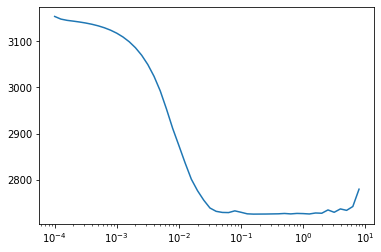

In [29]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-7, 1e-4, 0, 30])

In [35]:
# Clear session
keras.backend.clear_session()

# Set random seed
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  #keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
])

#optimizer = keras.optimizers.Adam(learning_rate=10e-2)
optimizer = keras.optimizers.Adam()

model.compile(loss= "mae", #keras.losses.Huber(),
              #optimizer= keras.optimizers.SGD(learning_rate=10e-2, momentum=0.9),
              optimizer= optimizer,
              metrics=["mae"])

# O parâmetro patience é o quantidade de epochs para checar as melhoras
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10)

# Callback to save the best weights during training process
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mae',
    mode='min',
    save_best_only=True)

# Default model checkpoint
#model_checkpoint = keras.callbacks.ModelCheckpoint("/tmp/checkpoint_model", save_best_only=True)

# Fit the model
history = model.fit(x=train_windows, #train_set,
                    y=train_labels, 
                    epochs=100,
                    verbose=0,
                    validation_data=(test_windows, test_labels), #test_set,
                    callbacks=[early_stop, model_checkpoint_callback])

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

#model = keras.models.load_model("my_checkpoint")

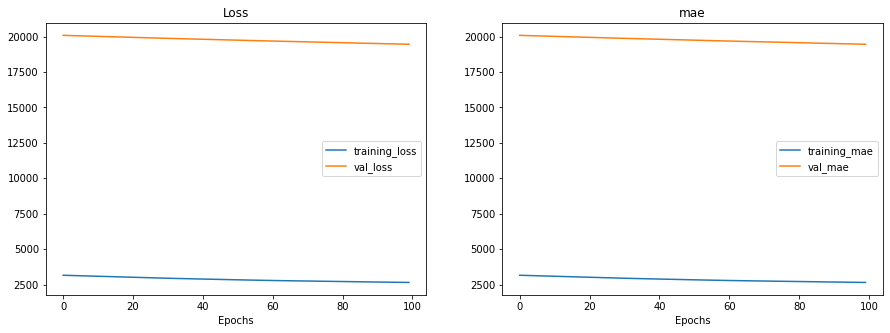

In [36]:
plot_loss_curves(history, metric="mae")

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Evaluate model on test data
model.evaluate(test_set)

18/18 [==============================] - 0s 3ms/step - loss: 19458.7109 - mae: 19458.7109


[19458.7109375, 19458.7109375]

In [39]:
# Evaluate model on test data
model.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 19458.7109 - mae: 19458.7109


[19458.7109375, 19458.7109375]

In [40]:
# Make predictions using model_1 on the test dataset and view the results
model_preds = make_preds(model, test_set)

# Evaluate preds
model_results = evaluate_preds(y_true=y_test, # reduce to right shape
                                 y_pred=model_preds)
model_results

{'mae': 19458.71,
 'mape': 94.651566,
 'mase': 34.183567,
 'mse': 685838200.0,
 'rmse': 26188.514}

In [41]:
compare_baseline_to_new_results(naive_results, model_results)

Baseline mae: 569.24, New mae: 19458.71, Difference: 18889.47
Baseline mse: 1151345.88, New mse: 685838208.00, Difference: 684686848.00
Baseline rmse: 1073.01, New rmse: 26188.51, Difference: 25115.51
Baseline mape: 2.52, New mape: 94.65, Difference: 92.13
Baseline mase: 1.00, New mase: 34.18, Difference: 33.18


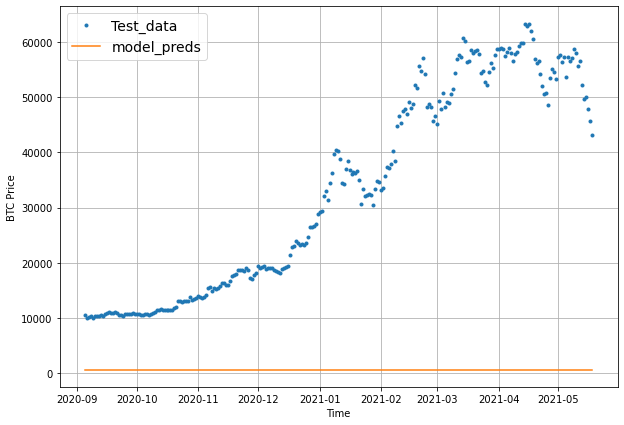

In [42]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=y_test.index, values=test_labels, start=offset, label="Test_data")
plot_time_series(timesteps=y_test.index, values=model_preds, start=offset, format="-", label="model_preds")